In [29]:
# load libraries
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup

In [76]:
df = pd.read_parquet("df-FULL.parquet")
df.index = range(0, len(df))

In [99]:
beginner = '''Amumu,Annie,Ashe,Cho'Gath,Dr. Mundo,Garen,Janna,Jinx,Malphite,Malzahar,Maokai,Nasus,Nautilus,Nocturne,Nunu & Willump,Olaf,Rammus,Shyvana,Sivir,Skarner,Soraka,Teemo,Tristana,Trundle,Udyr'''

novice = '''Alistar,Blitzcrank,Brand,Braum,Darius,Diana,Galio,Hecarim,Jarvan IV,Jax,Karma,Karthus,Kog'Maw,Leona,Lucian,Lulu,Lux,Master Yi,Miss Fortune,Morgana,Neeko,Pantheon,Renekton,Sejuani,Seraphine,Shen,Sion,Sona,Swain,Taric,Tryndamere,Veigar,Vi,Volibear,Warwick,Wukong,Xin Zhao,Zac,Ziggs'''

intermediate = '''Ahri,Cassiopeia,Corki,Ekko,Elise,Ezreal,Fiora,Fizz,Gragas,Graves,Kai'Sa,Kassadin,Kayn,Kennen,Kha'Zix,Lissandra,Nami,Ornn,Poppy,Pyke,Rakan,Rek'Sai,Sett,Talon,Twitch,Varus,Vayne,Vel'Koz,Viktor,Xayah,Xerath,Zilean,Rell'''

high = '''Anivia,Aurelion Sol,Evelynn,Fiddlesticks,Gnar,Heimerdinger,Illaoi,Ivern,Jayce,Jhin,Kalista,Kayle,Kled,Mordekaiser,Quinn,Rengar,Rumble,Ryze,Shaco,Singed,Tahm Kench,Taliyah,Twisted Fate,Urgot,Vladimir,Yorick,Yuumi,Zyra'''

advanced = '''Aatrox,Bard,Caitlyn,Draven,Kindred,LeBlanc,Orianna,Senna,Sylas,Syndra,Thresh,Yone,Zed,Viego,Vex,Gwen,Akshan'''

expert = '''Akali,Aphelios,Azir,Camille,Gangplank,Irelia,Katarina,Lee Sin,Lillia,Nidalee,Qiyana,Riven,Samira,Yasuo,Zoe,Renata Glasc,Zeri'''

beginner = beginner.split(',')
novice = novice.split(',')
intermediate = intermediate.split(',')
high = high.split(',')
advanced = advanced.split(',')
expert = expert.split(',')

In [100]:
for row in df['Champion'].index:
    if df['Champion'][row] in beginner:
        df.at[row, 'Champion'] = "Beginner"
    elif df['Champion'][row] in novice:
        df.at[row, 'Champion'] = "Novice"
    elif df['Champion'][row] in intermediate:
        df.at[row, 'Champion'] = "Intermediate"
    elif df['Champion'][row] in high:
        df.at[row, 'Champion'] = "High"
    elif df['Champion'][row] in advanced:
        df.at[row, 'Champion'] = "Advanced"
    elif df['Champion'][row] in expert:
        df.at[row, 'Champion'] = "Expert"

In [105]:
# Análisis Nulos por columnas
nulos_col = pd.merge(df.isnull().sum().sort_values().to_frame('missing_value').reset_index(),
         df.dtypes.to_frame('feature_type').reset_index(),
         on = 'index',
         how = 'inner')
nulos_col['columns_percentage'] = nulos_col['missing_value']/df.shape[0]
nulos_col.sort_values(['missing_value', 'feature_type', 'columns_percentage'], ascending=False)

,index,missing_value,feature_type,columns_percentage
5,Games Played,6887,float64,0.036715
6,Winrate,6887,float64,0.036715
7,KDA,6887,float64,0.036715
8,CS per minute,6887,float64,0.036715
0,Summoner Name,0,object,0.000000
1,Champion,0,object,0.000000
2,Summoner Winrate,0,float64,0.000000
4,WinRate Last 5,0,float64,0.000000
3,Result,0,int32,0.000000


In [104]:
df['Result'] = df['Result'].astype('int')
df['CS per minute'] = df['CS per minute'].astype('float')

df = df.loc[df['Result'] != 99]

In [106]:
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, KFold

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, \
                            silhouette_score, recall_score, precision_score, make_scorer, \
                            roc_auc_score, f1_score, precision_recall_curve

from sklearn.metrics import accuracy_score, roc_auc_score, \
                            classification_report, confusion_matrix


from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix

In [107]:
import lightgbm
from sklearn.model_selection import train_test_split
from aux_func import evaluate_model, model_analysis

#Combining numerical and categorical piepline into one big pipeline horizontally using ColumnTransformer
from sklearn.compose import ColumnTransformer

## No podemos utilizar TransformTargetRegression porque estamos en un modelo de clasificacion
# from 'Y' and 'N' to numeric values
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [108]:
#Defining the steps in the numerical pipeline 
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0))])

#Defining the steps in the categorical pipeline 
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])
    
    
#Numerical features to pass down the numerical pipeline 
numeric_features = df.select_dtypes(include=['int64', 'int32', 'float64', 'float32']).drop(['Result'], axis=1).columns

#Categrical features to pass down the categorical pipeline 
categorical_features = df.drop(["Summoner Name"], axis=1).select_dtypes(include=['object']).columns

In [113]:
import xgboost as xgb

In [114]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

classifiers = [
    lightgbm.LGBMClassifier(),
    xgb.XGBClassifier(),
    RandomForestClassifier()
    ]

In [115]:
x, y = df.drop(["Summoner Name", "Result"], axis=1), df['Result']
xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=0.2,random_state=0)

In [118]:
import warnings
warnings.filterwarnings('ignore')

In [119]:
for classifier in classifiers:
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', classifier)])
    pipe.fit(xtrain, ytrain)   
    print(classifier)
    print("model score: %.3f" % pipe.score(xtest, ytest))

LGBMClassifier()
model score: 0.637
[21:55:51] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
model score: 0.631
RandomForestClass

In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
from sklearn import metrics
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, confusion_matrix, roc_curve
import pickle
from sklearn.metrics import ConfusionMatrixDisplay
import re
import matplotlib
from sklearn.model_selection import GridSearchCV


In [127]:
import lightgbm

In [140]:
model = Pipeline(steps=[('preprocessor', preprocessor),
                      ('clasificador', lightgbm.LGBMClassifier())])

param_grid = { 
    'clasificador__is_unbalance': [False],
    'clasificador__max_depth': [-1],
    'clasificador__objective': ['binary'],
    'clasificador__learning_rate': [0.1, 0.05, 0.025], 
    'clasificador__n_estimators' : [200, 300, 400, 500], 
    'clasificador__importance_type' : ['split', 'gain'],
    'clasificador__num_leaves': [50, 100, 150, 200]
    }

CV = GridSearchCV(model, param_grid, cv=10, n_jobs=-1, scoring='accuracy', verbose=10)
CV.fit(xtrain, ytrain)

Fitting 10 folds for each of 96 candidates, totalling 960 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value=0,
                                                                                                        strategy='constant'))]),
                                                                         Index(['Games Played', 'Winrate', 'KDA', 'CS per minute', 'Summoner Winrate',
       'WinRate Last 5'],
      dtype='object')),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value

In [142]:
CV.best_params_

{'clasificador__importance_type': 'split',
 'clasificador__is_unbalance': False,
 'clasificador__learning_rate': 0.025,
 'clasificador__max_depth': -1,
 'clasificador__n_estimators': 200,
 'clasificador__num_leaves': 50,
 'clasificador__objective': 'binary'}

In [143]:
ypred = CV.predict(xtest)
ypred_proba = CV.predict_proba(xtest)

In [146]:
evaluate_model(ytest, ypred, ypred_proba)

ROC-AUC score of the model: 0.7035211576064775
Accuracy of the model: 0.6381107231388438

Classification report: 
              precision    recall  f1-score   support

           0       0.65      0.55      0.59     18069
           1       0.63      0.72      0.67     19448

    accuracy                           0.64     37517
   macro avg       0.64      0.63      0.63     37517
weighted avg       0.64      0.64      0.64     37517


Confusion matrix: 
[[ 9935  8134]
 [ 5443 14005]]



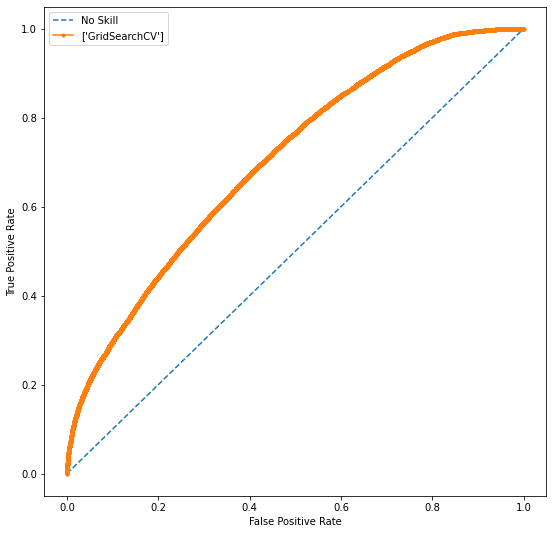

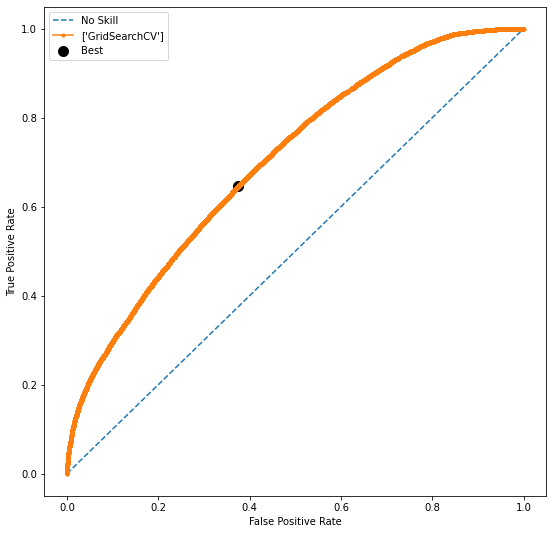

ROC-AUC score of the model: 0.7035211576064775
Accuracy of the model: 0.6359783564783965

Classification report: 
              precision    recall  f1-score   support

           0       0.62      0.63      0.62     18069
           1       0.65      0.65      0.65     19448

    accuracy                           0.64     37517
   macro avg       0.64      0.64      0.64     37517
weighted avg       0.64      0.64      0.64     37517


Confusion matrix: 
[[11308  6761]
 [ 6896 12552]]



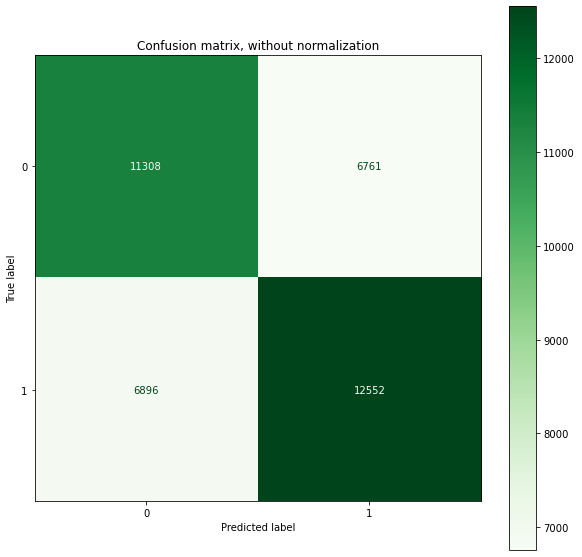

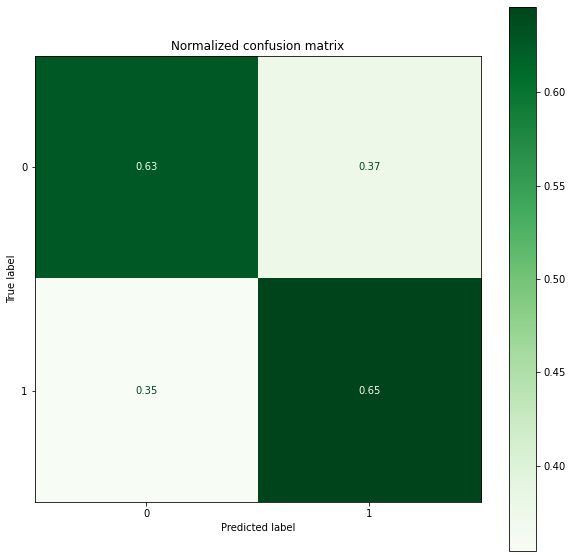

In [147]:
model_analysis(CV, xtest, ytest)